# Predicción de Lluvia en Australia

### Facultad de Ciencias Exactas, Ingeniería y Agrimensura  
### Tecnicatura en Inteligencia Artificial  
### Aprendizaje Automático 1  

**Trabajo Práctico**: Predicción de lluvia utilizando modelos de clasificación y redes neuronales.

**Autores**:  
- Avecilla Tomas 
- Calcia Franco  

 

---

### Objetivo
Desarrollar un modelo de predicción de la variable `RainTomorrow` basado en datos climáticos de Australia, utilizando técnicas de pre-procesamiento, modelado, evaluación y optimización de modelos, para su posterior puesta en producción.



### Diccionario de Datos

| Variable         | Descripción                                                       | Tipo        | Ejemplo       
|-------------------|------------------------------------------------------------------|-------------|---------------
| **Date**          | Fecha de la observación del clima.                               | object      | 2010-01-01    
| **Location**      | Ciudad donde se realizó la medición del clima.                  | object      | Sydney        
| **MinTemp**       | Temperatura mínima del día (en grados Celsius).                 | float64     | 12.3          
| **MaxTemp**       | Temperatura máxima del día (en grados Celsius).                 | float64     | 28.9          
| **Rainfall**      | Cantidad de lluvia caída en milímetros durante el día.          | float64     | 0.0           
| **Evaporation**   | Evaporación en milímetros durante el día.                       | float64     | 0.0           
| **Sunshine**      | Horas de sol durante el día.                                    | float64     | 8.0           
| **WindGustDir**   | Dirección del viento racheado (en grados).                      | object      | NNE           
| **WindGustSpeed** | Velocidad del viento racheado (en km/h).                        | float64     | 15.0          
| **WindDir9am**    | Dirección del viento a las 9 am.                                | object      | NNE           
| **WindDir3pm**    | Dirección del viento a las 3 pm.                                | object      | SSE          
| **WindSpeed9am**  | Velocidad del viento a las 9 am (en km/h).                     | float64     | 5.0           
| **WindSpeed3pm**  | Velocidad del viento a las 3 pm (en km/h).                     | float64     | 10.0          
| **Humidity9am**   | Humedad relativa a las 9 am (%).                               | float64     | 65.0          
| **Humidity3pm**   | Humedad relativa a las 3 pm (%).                               | float64     | 55.0          
| **Pressure9am**   | Presión atmosférica a las 9 am (hPa).                          | float64     | 1012.0        
| **Pressure3pm**   | Presión atmosférica a las 3 pm (hPa).                          | float64     | 1011.0        
| **Cloud9am**      | Cobertura nubosa a las 9 am (en octavos).                      | float64     | 2.0           
| **Cloud3pm**      | Cobertura nubosa a las 3 pm (en octavos).                      | float64     | 3.0           
| **Temp9am**       | Temperatura a las 9 am (en grados Celsius).                    | float64     | 15.0          
| **Temp3pm**       | Temperatura a las 3 pm (en grados Celsius).                    | float64     | 20.0          
| **RainToday**     | Indica si llovió hoy (Yes/No).                                 | object      | Yes           
| **RainTomorrow** _(Target)_ | Indica si lloverá mañana (Yes/No).                             | object      | No            


## Preparación del entorno de trabajo

In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import RobustScaler,StandardScaler


In [289]:
df_clima = pd.read_csv("weatherAUS.csv")

## Análisis Exploratorio

In [290]:
df_clima.tail()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No
145459,2017-06-25,Uluru,14.9,NaN,0.0,NaN,NaN,NaN,NaN,ESE,...,62.0,36.0,1020.2,1017.9,8.0,8.0,15.0,20.9,No,NaN


In [291]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Notamos que tenemos que cambiar el tipo de ciertas columnas

In [292]:
df_clima['Date'] = pd.to_datetime(df_clima['Date'])
df_clima = df_clima.sort_values(by='Date', ascending=True)

df_clima = pd.get_dummies(df_clima, columns=['RainToday', 'RainTomorrow'], drop_first=True)
# Renombrar las columnas
df_clima = df_clima.rename(columns={'RainToday_Yes': 'RainToday', 'RainTomorrow_Yes': 'RainTomorrow'})


Nos encontramos con otras columnas de tipo object y vamos a verificarlas antes de transformarlas

In [293]:
df_clima["WindDir3pm"].unique()

array(['NW', 'W', 'NNE', 'ESE', 'E', 'ENE', 'WSW', 'NE', 'NNW', 'SE', 'S',
       'SW', 'WNW', 'N', 'SSW', 'SSE', nan], dtype=object)

In [294]:
df_clima["WindDir9am"].unique()

array(['SW', 'E', 'N', 'WNW', 'SSE', 'SE', 'S', 'WSW', 'NNE', 'NNW',
       'ENE', 'SSW', 'NW', 'ESE', 'NE', 'W', nan], dtype=object)

In [295]:
df_clima["WindGustDir"].unique()

array(['NW', 'ENE', 'SSE', 'SE', 'E', 'S', 'N', 'WNW', 'ESE', 'NE', 'NNE',
       'NNW', 'SW', 'W', 'WSW', nan, 'SSW'], dtype=object)

In [296]:
df_clima["Location"].unique()

array(['Canberra', 'Sydney', 'Adelaide', 'Hobart', 'Melbourne',
       'Brisbane', 'Perth', 'Darwin', 'Albany', 'Newcastle', 'GoldCoast',
       'AliceSprings', 'Albury', 'Cairns', 'MountGambier', 'Penrith',
       'Ballarat', 'Bendigo', 'Wollongong', 'MountGinini', 'Townsville',
       'Tuggeranong', 'Launceston', 'Moree', 'Walpole', 'BadgerysCreek',
       'Williamtown', 'MelbourneAirport', 'PerthAirport', 'CoffsHarbour',
       'Woomera', 'PearceRAAF', 'Nuriootpa', 'Cobar', 'Sale',
       'SydneyAirport', 'WaggaWagga', 'Richmond', 'NorahHead', 'Mildura',
       'NorfolkIsland', 'Witchcliffe', 'Dartmoor', 'Watsonia', 'Portland',
       'SalmonGums', 'Uluru', 'Nhil', 'Katherine'], dtype=object)

Consideramos que es mejor pasar las variables a tipo categorico ya que tiene una cantidad de valores unicos limitada.

In [297]:
df_clima['WindDir9am'] = df_clima['WindDir9am'].astype('category')
df_clima['WindDir3pm'] = df_clima['WindDir3pm'].astype('category')
df_clima['WindGustDir'] = df_clima['WindGustDir'].astype('category')
df_clima['Location'] = df_clima['Location'].astype('category')

## Train-Test

In [298]:
X_train, X_test, y_train, y_test = train_test_split(df_clima.drop(columns=['RainTomorrow']), df_clima['RainTomorrow'], test_size=0.3, random_state=42)

df_entrenamiento = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)

## Analisis Exploratorio

### Limpieza de Datos

#### Manejo de Valores Faltantes/Nulos

In [299]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

Date                 0
Location             0
MinTemp           1047
MaxTemp            876
Rainfall          2319
Evaporation      43869
Sunshine         48751
WindGustDir       7182
WindGustSpeed     7135
WindDir9am        7384
WindDir3pm        2928
WindSpeed9am      1256
WindSpeed3pm      2116
Humidity9am       1879
Humidity3pm       3124
Pressure9am      10516
Pressure3pm      10497
Cloud9am         39145
Cloud3pm         41575
Temp9am           1256
Temp3pm           2502
RainToday            0
RainTomorrow         0
dtype: int64

Se puede observar que hay demasiados valores faltantes y ademas nuestro target tambien contiene

In [300]:
# Que porcentaje del total de cada columna hay valores faltantes
nan_percentage = (conteo_nan / len(df_entrenamiento)) * 100
missing_data = pd.DataFrame({'count': conteo_nan, 'percentage': nan_percentage})
print(missing_data)


               count  percentage
Date               0    0.000000
Location           0    0.000000
MinTemp         1047    1.028265
MaxTemp          876    0.860325
Rainfall        2319    2.277504
Evaporation    43869   43.084009
Sunshine       48751   47.878651
WindGustDir     7182    7.053485
WindGustSpeed   7135    7.007327
WindDir9am      7384    7.251871
WindDir3pm      2928    2.875606
WindSpeed9am    1256    1.233525
WindSpeed3pm    2116    2.078136
Humidity9am     1879    1.845377
Humidity3pm     3124    3.068099
Pressure9am    10516   10.327827
Pressure3pm    10497   10.309167
Cloud9am       39145   38.444540
Cloud3pm       41575   40.831058
Temp9am         1256    1.233525
Temp3pm         2502    2.457229
RainToday          0    0.000000
RainTomorrow       0    0.000000


Como primera medida eliminaremos las fila que tengan la variable de salida nula o 18 o más columnas nulas ya que las consideramos irrelevantes para el analisis

In [301]:
#Mantenemos las filas que contengan 18 o menos valores nulos
df_entrenamiento = df_entrenamiento.dropna(thresh=18)

#Eliminamos las filas que contienen la variable Target como nula
df_entrenamiento = df_entrenamiento.dropna(subset=['RainTomorrow'])

In [302]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date                 0
Location             0
MinTemp             77
MaxTemp             72
Rainfall          1298
Evaporation      33449
Sunshine         38010
WindGustDir       3159
WindGustSpeed     3139
WindDir9am        4668
WindDir3pm         432
WindSpeed9am        56
WindSpeed3pm        38
Humidity9am        377
Humidity3pm        826
Pressure9am        704
Pressure3pm        678
Cloud9am         30328
Cloud3pm         31818
Temp9am             67
Temp3pm            500
RainToday            0
RainTomorrow         0
dtype: int64

In [303]:
df_entrenamiento["RainToday"].value_counts()

RainToday
False    70451
True     19956
Name: count, dtype: int64

Decidimos imputar con la moda ya que es amplia la diferencia entre las dos categorias

In [304]:
df_entrenamiento["RainToday"] = df_entrenamiento["RainToday"].fillna(df_entrenamiento['RainToday'].mode()[0])

Decidimos imputar las variables que tengan debajo de 1000 valores faltantes con la media ya que el porcentaje que representan del total de filas es practicamente despreciable

In [305]:
# Identificar las columnas con menos de 1000 nulos
cols_with_few_nans = df_entrenamiento.columns[df_entrenamiento.isnull().sum() < 1000]

# Imputar con la media en las columnas seleccionadas
for col in cols_with_few_nans:
    if df_entrenamiento[col].dtype in ['float64', 'int64']:  # Solo columnas numéricas
        df_entrenamiento[col] = df_entrenamiento[col].fillna(df_entrenamiento[col].mean())


In [306]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall          1298
Evaporation      33449
Sunshine         38010
WindGustDir       3159
WindGustSpeed     3139
WindDir9am        4668
WindDir3pm         432
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am         30328
Cloud3pm         31818
Temp9am              0
Temp3pm              0
RainToday            0
RainTomorrow         0
dtype: int64

Hay columnas que cuentan con muchos valores nulos, vamos a ver su distribucion para tomar una mejor decision

<Axes: xlabel='Evaporation', ylabel='Density'>

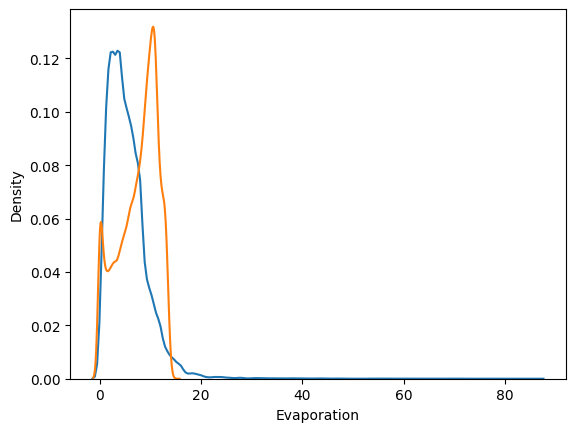

In [307]:
sns.kdeplot(df_entrenamiento["Evaporation"])
sns.kdeplot(df_entrenamiento["Sunshine"])

Podemos observar una clara distribucion asimetrica a la derecha por lo tanto imputamos con la mediana ya que es mas robusta

In [308]:
# Imputar los valores faltantes en 'Evaporation' y 'Sunshine' con la mediana
df_entrenamiento['Evaporation'] = df_entrenamiento['Evaporation'].fillna(df_entrenamiento['Evaporation'].median())
df_entrenamiento['Sunshine'] = df_entrenamiento['Sunshine'].fillna(df_entrenamiento['Sunshine'].median())


Hacemos lo mismo para las otras columnas

<Axes: xlabel='Cloud3pm', ylabel='Density'>

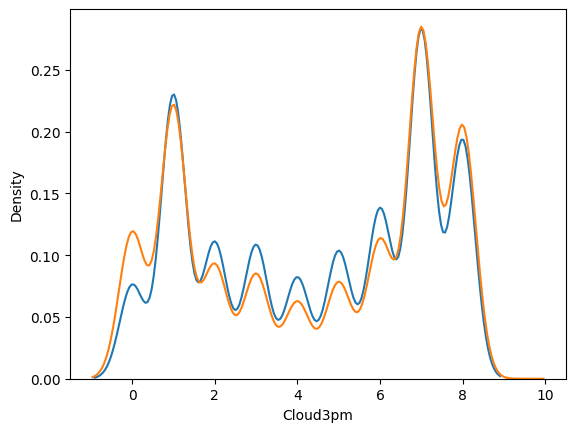

In [309]:
sns.kdeplot(df_entrenamiento["Cloud3pm"])
sns.kdeplot(df_entrenamiento["Cloud9am"])

Dada la distribucion temporal, elegimos una ventana de 14 dias porque podemos notar un patron mas estacional en terminos de nubosidad

In [310]:
df_entrenamiento['Cloud9am'] = df_entrenamiento['Cloud9am'].fillna(df_entrenamiento['Cloud9am'].rolling(window=14, min_periods=1).mean())
df_entrenamiento['Cloud3pm'] = df_entrenamiento['Cloud3pm'].fillna(df_entrenamiento['Cloud3pm'].rolling(window=14, min_periods=1).mean())

Ya que estas variables son object y no tienen una cantidad muy significativa de valores nulos, resolvimos el problema con propagacion de valores lo cual es util debido a la naturaleza temporal de los datos

In [311]:
df_entrenamiento['WindGustDir'] = df_entrenamiento['WindGustDir'].ffill()
df_entrenamiento['WindGustSpeed'] = df_entrenamiento['WindGustSpeed'].ffill()
df_entrenamiento['WindDir9am'] = df_entrenamiento['WindDir9am'].ffill()
df_entrenamiento['WindDir3pm'] = df_entrenamiento['WindDir3pm'].ffill()

In [312]:
nan_count_train = df_entrenamiento.isnull().sum()
nan_count_train

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall         1298
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            2
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
dtype: int64

#### Outliers

In [313]:
resultados_atipicos = {}

for columna in df_entrenamiento.columns:
    if df_entrenamiento[columna].dtype in ['int64', 'float64']:
        Q1 = df_entrenamiento[columna].quantile(0.25)
        Q3 = df_entrenamiento[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_entrenamiento[columna] < limite_inferior) | (df_entrenamiento[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_entrenamiento)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: MinTemp - Porcentaje de valores atípicos: 0.04%
Columna: MaxTemp - Porcentaje de valores atípicos: 0.08%
Columna: Rainfall - Porcentaje de valores atípicos: 17.70%
Columna: Evaporation - Porcentaje de valores atípicos: 11.21%
Columna: Sunshine - Porcentaje de valores atípicos: 24.87%
Columna: WindGustSpeed - Porcentaje de valores atípicos: 2.21%
Columna: WindSpeed9am - Porcentaje de valores atípicos: 0.98%
Columna: WindSpeed3pm - Porcentaje de valores atípicos: 1.86%
Columna: Humidity9am - Porcentaje de valores atípicos: 1.32%
Columna: Humidity3pm - Porcentaje de valores atípicos: 0.00%
Columna: Pressure9am - Porcentaje de valores atípicos: 1.07%
Columna: Pressure3pm - Porcentaje de valores atípicos: 0.76%
Columna: Cloud9am - Porcentaje de valores atípicos: 0.00%
Columna: Cloud3pm - Porcentaje de valores atípicos: 0.00%
Columna: Temp9am - Porcentaje de valores atípicos: 0.06%
Columna: Temp3pm - Porcentaje de valores atípicos: 0.23%


Podemos notar que en la gran mayoria de columnas no vemos una cantidad significativa de valores atipicos por lo cual no los trataremos de ninguna manera.

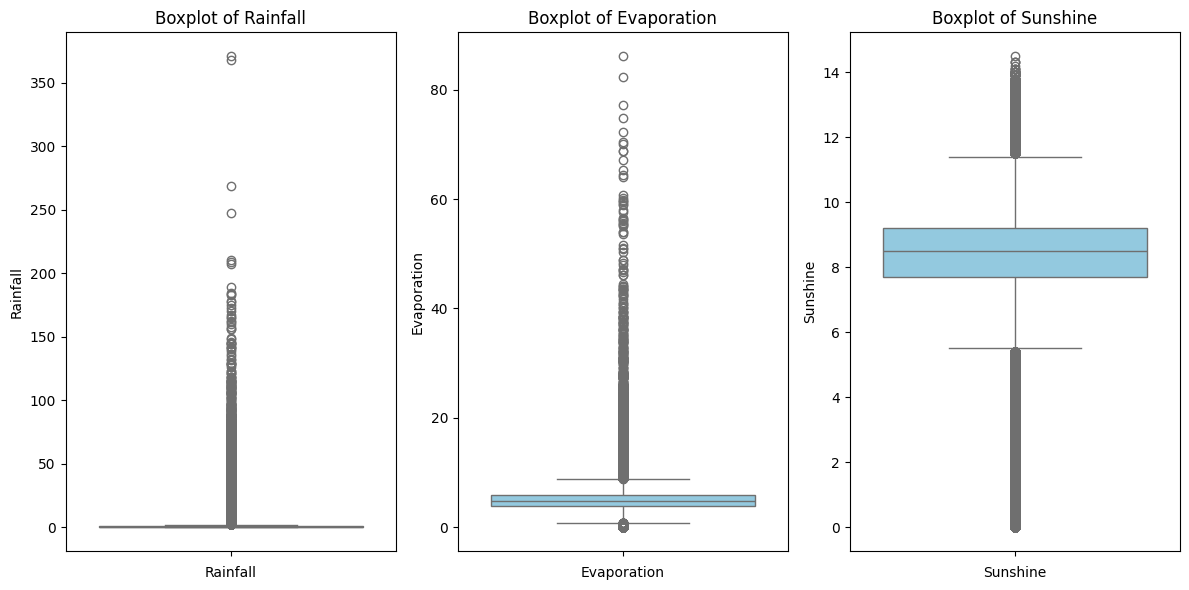

In [314]:
columns = ['Rainfall', 'Evaporation', 'Sunshine']

data_subset = df_entrenamiento[columns]

plt.figure(figsize=(12, 6))

for i, column in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data_subset[column], color='skyblue')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)

plt.tight_layout()

plt.show()


Los valores atípicos pueden ser de eventos meteorológicos extremos que consideramos parte de la variabilidad natural del clima. Estos outliers, observados en las variables de **(Rainfall)**, **(Evaporation)** y **(Sunshine)**, reflejan condiciones climáticas inusuales como tormentas, sequías o variaciones extremas en la radiación solar, todos los cuales son eventos importantes para un análisis completo del clima.

Tambien consideramos pertinente mencionar que las variables **(Evaporation)** y **(Sunshine)** sufrieron una alteracion en su distribucion dada su gran cantidad de valores nulos en el dataset inicial

### Analisis Descriptivo

Vamos a visualizar un poco como se distribuyen y comportan nuestros datos para ponernos en contexto antes de comenzar con los modelos.

In [315]:
df_entrenamiento.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,90407,90407.000000,90407.000000,89109.000000,90407.000000,90407.000000,90407.000000,90407.000000,90407.000000,90407.000000,90407.000000,90407.000000,90407.000000,90405.000000,90407.000000,90407.000000,90407.000000
mean,2013-03-25 22:59:53.270432768,12.426429,23.423014,2.348739,5.221001,7.997244,40.158561,14.349869,19.098496,68.486616,51.359016,1017.627287,1015.241130,4.448925,4.510797,17.183332,21.851150
min,2007-11-02 00:00:00,-8.200000,2.600000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-3.100000,1.700000
25%,2011-01-07 00:00:00,7.900000,18.000000,0.000000,3.800000,7.700000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.500000,2.875000,3.000000,12.400000,16.700000
50%,2013-05-20 00:00:00,12.200000,22.800000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,69.000000,52.000000,1017.627287,1015.241130,4.666667,4.714286,16.800000,21.300000
75%,2015-05-28 00:00:00,17.000000,28.400000,0.800000,5.800000,9.200000,48.000000,20.000000,24.000000,82.000000,65.000000,1022.300000,1020.000000,7.000000,6.100000,21.700000,26.500000
max,2017-06-25 00:00:00,33.900000,48.100000,371.000000,86.200000,14.500000,135.000000,87.000000,76.000000,100.000000,100.000000,1041.000000,1038.900000,9.000000,8.000000,40.200000,46.100000
std,NaN,6.327942,6.967846,8.504186,3.328700,2.908919,13.475275,8.814945,8.687678,18.905044,20.531252,7.070420,7.000249,2.422121,2.261043,6.418245,6.764932


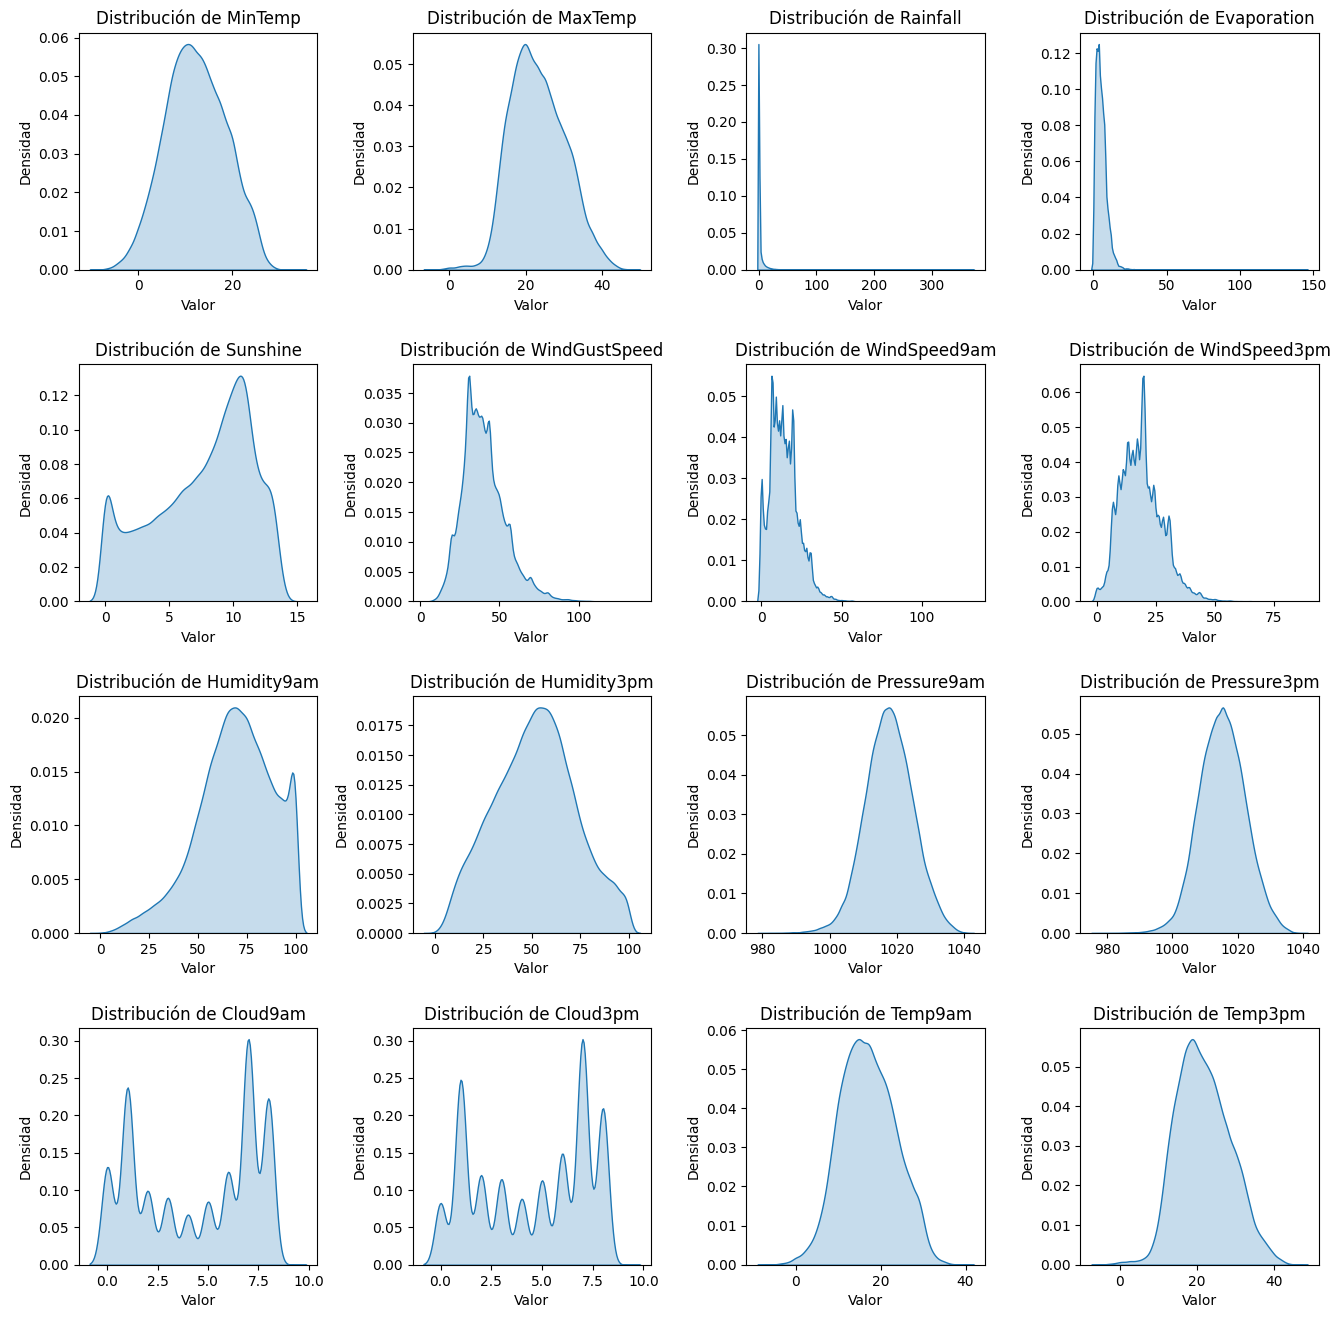

In [316]:
# Filtrar las columnas numéricas del dataframe
df_numerico = df_clima.select_dtypes(include=['float64', 'int64'])

# Determinar el número de variables numéricas
num_vars = len(df_numerico.columns)

# Configurar la figura y las subplots
fig, axes = plt.subplots(nrows=(num_vars // 4) + (num_vars % 4 > 0), ncols=4, figsize=(16, num_vars))

# Ajustar espacio entre los gráficos
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Recorrer las columnas y plotear cada una en su propio subplot
for i, column in enumerate(df_numerico.columns):
    row, col = divmod(i, 4)
    sns.kdeplot(df_numerico[column], ax=axes[row, col], fill=True)
    axes[row, col].set_title(f'Distribución de {column}')
    axes[row, col].set_xlabel('Valor')
    axes[row, col].set_ylabel('Densidad')

# Eliminar gráficos vacíos si no se llena la última fila
for j in range(i + 1, axes.size):
    fig.delaxes(axes.flat[j])

plt.show()


Al analizar las distribuciones de las variables numéricas a través de gráficos de KDE, observamos varios patrones.

1. **Distribuciones Normales**:
   Algunas variables muestran una distribución simétrica, similar a la curva de campana característica de la **distribución normal**.

2. **Distribuciones Asimétricas (Sesgo)**:
   Otras variables presentan **sesgo**, ya sea positivo o negativo..
   
   - **Implicación**: Estas variables pueden requerir transformaciones para mejorar su simetría. Esto facilitará la aplicabilidad para los modelos.

3. **Distribuciones Multimodales**:
   Se observan algunas variables con **distribuciones multimodales**, es decir, con varios picos en su densidad. Esto podría sugerir la existencia de **subgrupos** lo cual es normal ya que los datos son climaticos y puede llegar a tener algo que ver con las estaciones.

4. **Presencia de Outliers**:
   Varias variables muestran distribuciones con **colas largas**, lo que indica la presencia de **outliers** los cuales ya feuron estudiados previamente.



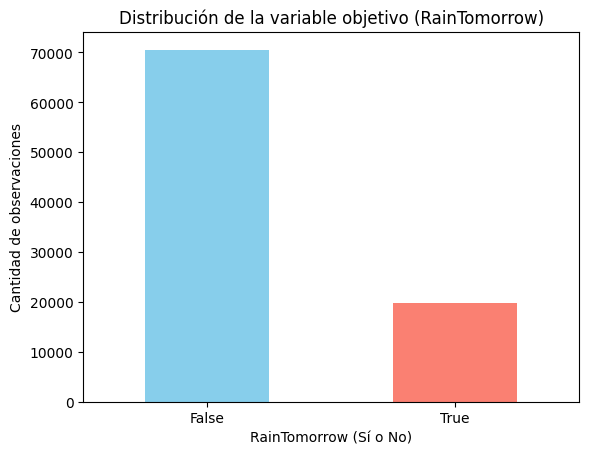

In [317]:

df_entrenamiento['RainTomorrow'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])

plt.title('Distribución de la variable objetivo (RainTomorrow)')
plt.xlabel('RainTomorrow (Sí o No)')
plt.ylabel('Cantidad de observaciones')
plt.xticks(rotation=0)
plt.show()


Vemos que hay una amplia diferencia entre los dos valores de la variable target

Predicción Acertada
True     59368
False    31039
Name: count, dtype: int64


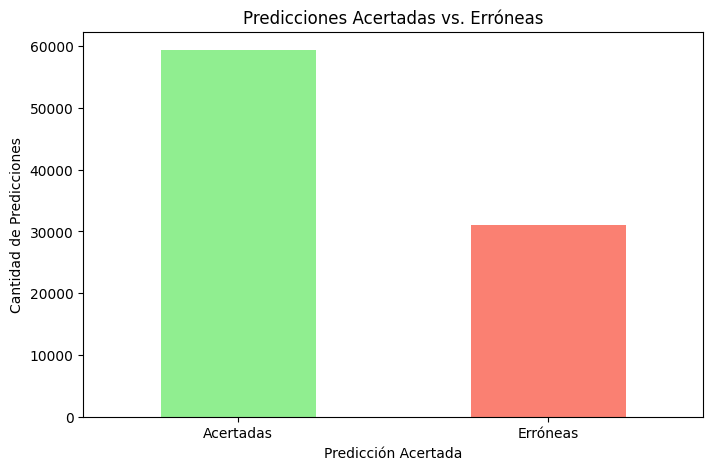

In [320]:
# Crear una copia de las columnas relevantes
df_aciertos = df_entrenamiento[['RainToday', 'RainTomorrow']].copy()

# Comparar RainToday de la fila actual con RainTomorrow de la fila anterior
# shift() mueve la columna RainTomorrow una fila hacia abajo
df_aciertos['Predicción Acertada'] = df_aciertos['RainToday'] == df_aciertos['RainTomorrow'].shift(1)

# Contar las predicciones acertadas y erróneas
conteo_aciertos = df_aciertos['Predicción Acertada'].value_counts()

# Mostrar conteo de aciertos
print(conteo_aciertos)

# Graficar los resultados
plt.figure(figsize=(8, 5))
conteo_aciertos.plot(kind='bar', color=['lightgreen', 'salmon'])

plt.title('Predicciones Acertadas vs. Erróneas')
plt.xlabel('Predicción Acertada')
plt.ylabel('Cantidad de Predicciones')
plt.xticks(ticks=[0, 1], labels=['Acertadas', 'Erróneas'], rotation=0)

plt.show()


Considerando la informacion que proporcionan las variables analizamos las veces que las 'predicciones' de si llovera mañana fueron correctas y observamos que se ha podido predecir con cierto grado de efectividad pero podia ser mejor.

### Exploracion de Dimensionalidad
Dado que el dataset contiene un número considerable de columnas, lo que puede incrementar la complejidad del análisis debido a la alta dimensionalidad, hemos decidido explorar esta característica. El objetivo es ver si es posible reducir la cantidad de variables, simplificando el modelo sin perder información valiosa y mejorando así la eficiencia de las tareas analíticas posteriores.

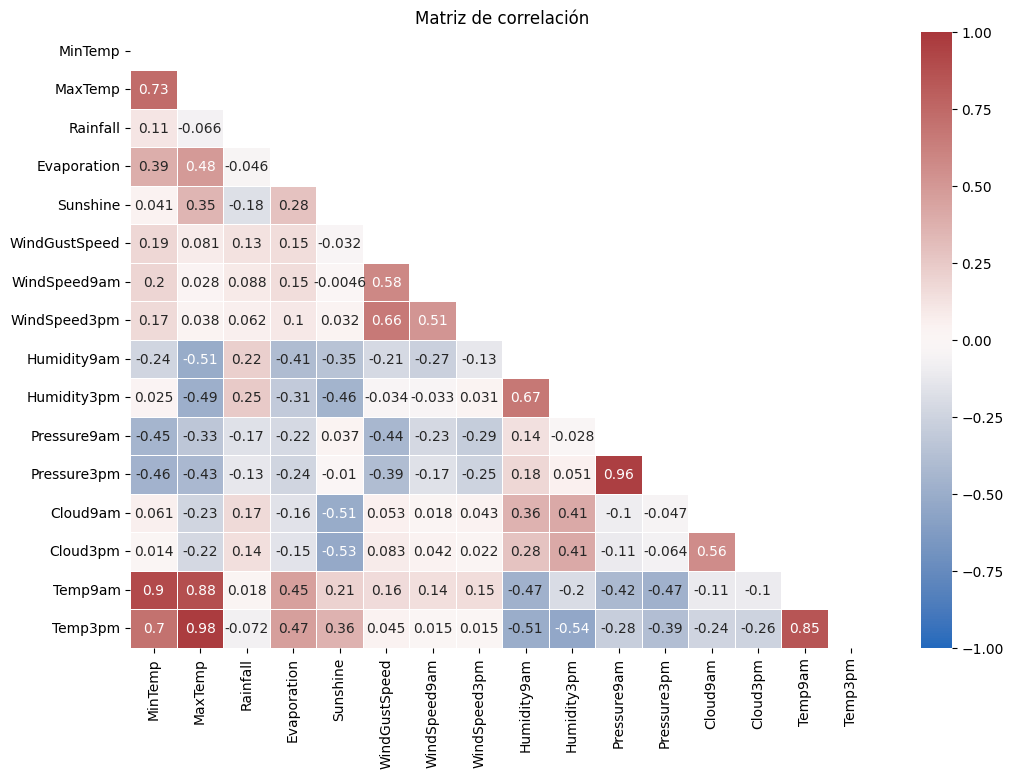

In [319]:

df_numerico = df_entrenamiento.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = df_numerico.corr()

# Crear la máscara
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Crear el colormap
colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Graficar el heatmap de la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()
